In [63]:
import pypsa
import matplotlib.pyplot as plt
import pandas as pd
import myUtils as utils

rootPath = "../../results/scenario/warm"
pathTail = "/networks/base_s_27_3H_3H_2045.nc"



plt.style.use('bmh')
%matplotlib inline

nBase = pypsa.Network(f"../../results/scenario/base{pathTail}")
nMean = pypsa.Network(f"{rootPath}_mean/{pathTail}")
nGood = pypsa.Network(f"{rootPath}_good/{pathTail}")
nBest = pypsa.Network(f"{rootPath}_best/{pathTail}")

networks = {
  "Sehr Optimistisch": nBest,
  "Optimistisch": nGood,
  "Mittel": nMean,
  "Basis": nBase,
}

INFO:pypsa.io:Imported network base_s_27_3H_3H_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_27_3H_3H_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_27_3H_3H_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_27_3H_3H_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


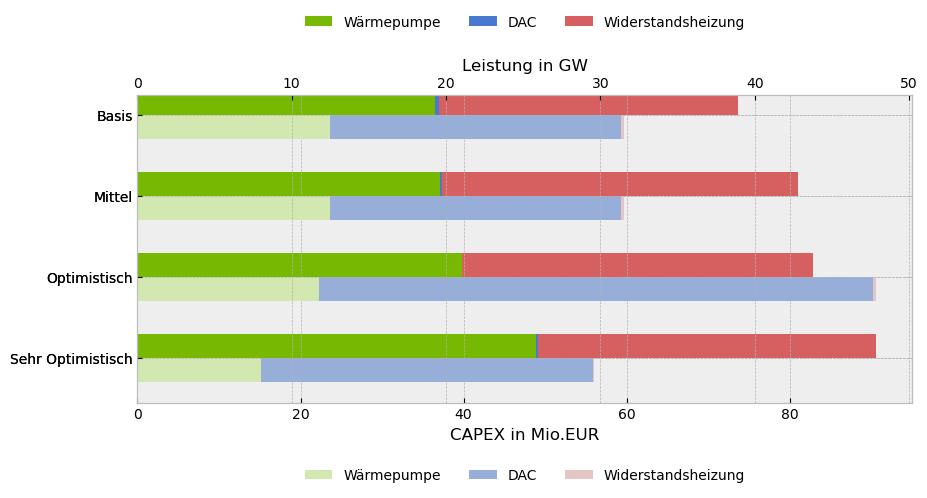

                   Wärmepumpe     DAC  Widerstandsheizung
Sehr Optimistisch    48.87316 0.28822            41.38777
Optimistisch         39.82575 0.00004            43.02294
Mittel               37.07630 0.30980            43.64877
Basis                36.48457 0.54844            36.68397


Bad pipe message: %s [b'ragma: no']
Bad pipe message: %s [b'ache\r\nProxy-Connection: keep-alive\r\nAccept: ', b'*\r\nUser-Agent: V2rayU/4.2.5 CFNetwork/156', b'100.1.1.1 Darwin/24.0.0\r\nAccept-Language: en-US,en;q=0.']


In [66]:
import pandas as pd
import myUtils as utils
import importlib
importlib.reload(utils)

import seaborn as sns
plt.style.use('seaborn-v0_8-muted')
sns.color_palette("muted")

dfP = pd.DataFrame()
dfPrice = pd.DataFrame()

for key, n in networks.items():
  sp = pd.Series()
  sprice =  pd.Series()

  warm = utils.getNByGroup(n,'Link', utils.de_warm_link)
  p0 = warm.groupby('carrier')['p_nom_opt'].sum() / 1e3
  price = warm.groupby('carrier')['capital_cost'].sum() / 1e6
  
  sp['Wärmepumpe'] = p0['rural air heat pump'] + p0['rural ground heat pump'] + p0['urban central air heat pump'] + p0['urban decentral air heat pump']
  sp['Widerstandsheizung'] =p0['urban central resistive heater'] + p0['rural resistive heater'] + p0['urban decentral resistive heater']
  sp['DAC'] = p0['DAC']
  
  sprice['Wärmepumpe'] =  price['rural air heat pump'] + price['rural ground heat pump'] + price['urban central air heat pump'] + price['urban decentral air heat pump']
  sprice['DAC'] = price['DAC']
  sprice['Widerstandsheizung'] =price['urban central resistive heater'] + price['rural resistive heater'] + price['urban decentral resistive heater']

  sp.reindex(['Wärmepumpe', 'Widerstandsheizung', 'DAC'])
  sprice.reindex(['Wärmepumpe', 'Widerstandsheizung', 'DAC'])

  dfP[key] = sp
  dfPrice[key] = sprice
    


dfP = dfP.transpose()
dfP = dfP[['Wärmepumpe', 'DAC', 'Widerstandsheizung']]

new_order = ['Basis', 'Mittel', 'Optimistisch', 'Sehr Optimistisch']
dfP.reindex(new_order)
dfPrice.reindex(new_order)

dfPrice = dfPrice.transpose()

colorP={
  'Wärmepumpe': '#76B802',
  'Widerstandsheizung': '#D65F5F',
  'DAC': '#4878D0'
}

colorPrice={
  'Wärmepumpe': '#D3E8B0',
  'Widerstandsheizung': '#E5C6C6',
  'DAC': '#97AED9'
}

fig, ax1 = plt.subplots()



bars1= dfP.plot(kind='barh',  ax=ax1,  position=0, width=0.3, label='Dataset 1', stacked=True, color=colorP, figsize=(10,4))

ax2 = ax1.twiny()
dfPrice.plot(kind='barh',  ax=ax2, position=1, width=0.3, label='Dataset 2', stacked=True, color= colorPrice, figsize=(10,4))

ax2.set_xlabel('Leistung in GW')
ax1.set_xlabel('CAPEX in Mio.EUR')

ax1.legend(loc='upper center', ncol=3, frameon=False, bbox_to_anchor=(0.5, 1.3))
ax2.legend(loc='lower center',ncol=3, frameon=False, bbox_to_anchor=(0.5, -0.3))



plt.show()

print(dfP)